# Importar Recursos

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset = load_dataset("simonMadec/VegAnn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3775 [00:00<?, ? examples/s]

# Obtención de datos

In [ ]:
# Selección de imágenes
X_imgs = dataset['train'][:100]['image']

In [ ]:
# Convertir imágenes a Numpy array
X_imgs = [np.array(img) for img in X_imgs]

In [ ]:
# Convertir imágenes a forma RGB
X_imgs_rgb = [img.reshape(-1,3) for img in X_imgs]

# Segmentación por KMeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def is_green(color):
    R, G, B = color
    r_crit = R < G #0.8
    b_crit = B < G #0.64
    return (r_crit and b_crit)

In [ ]:
def green_scores(model, image_rgb):
    green_sc = []
    for cat in np.unique(model.labels_):
        X_cat = image_rgb[model.labels_ == cat]
        scores = np.fromiter((is_green(pix) for pix in X_cat), np.float64)
        green_sc.append(scores.mean())
    return green_sc

In [ ]:
# Numero de agrupamientos a formar
clusters = 6
model = KMeans(n_clusters=clusters, n_init='auto')

In [ ]:
# Ajustando el modelo a la imagen
n = 99
model.fit(X_imgs_rgb[n])

KMeans(n_clusters=6, n_init='auto')

In [ ]:
# Score de nivel de verde
gr_sc = green_scores(model, X_imgs_rgb[n])
n_cluster = np.array(gr_sc).argmax()

# Pipeline

In [ ]:
# Numero de agrupamientos a formar
clusters = 5
model = KMeans(n_clusters=clusters, n_init='auto')

In [ ]:
masks = []

for img in X_imgs:
    # Convertir imágenes a forma RGB
    img_rgb = img.reshape(-1,3)

    # Segmentar en 2 colores
    model.fit(img_rgb)

    # Scorde de nivel de verde
    green_sc = green_scores(model, img_rgb)
    n_cluster = np.array(green_sc).argmax()

    # Mascara del cluster escogido
    # mask_rgb = mask_cluster(model, n_cluster)
    mask_rgb = model.labels_ == n_cluster

    # Regresar al formato de imagen
    mask = mask_rgb.reshape(img.shape[0], img.shape[1])
    masks.append(mask)

# Test

In [ ]:
indx = np.random.randint(0,100, size = 10)

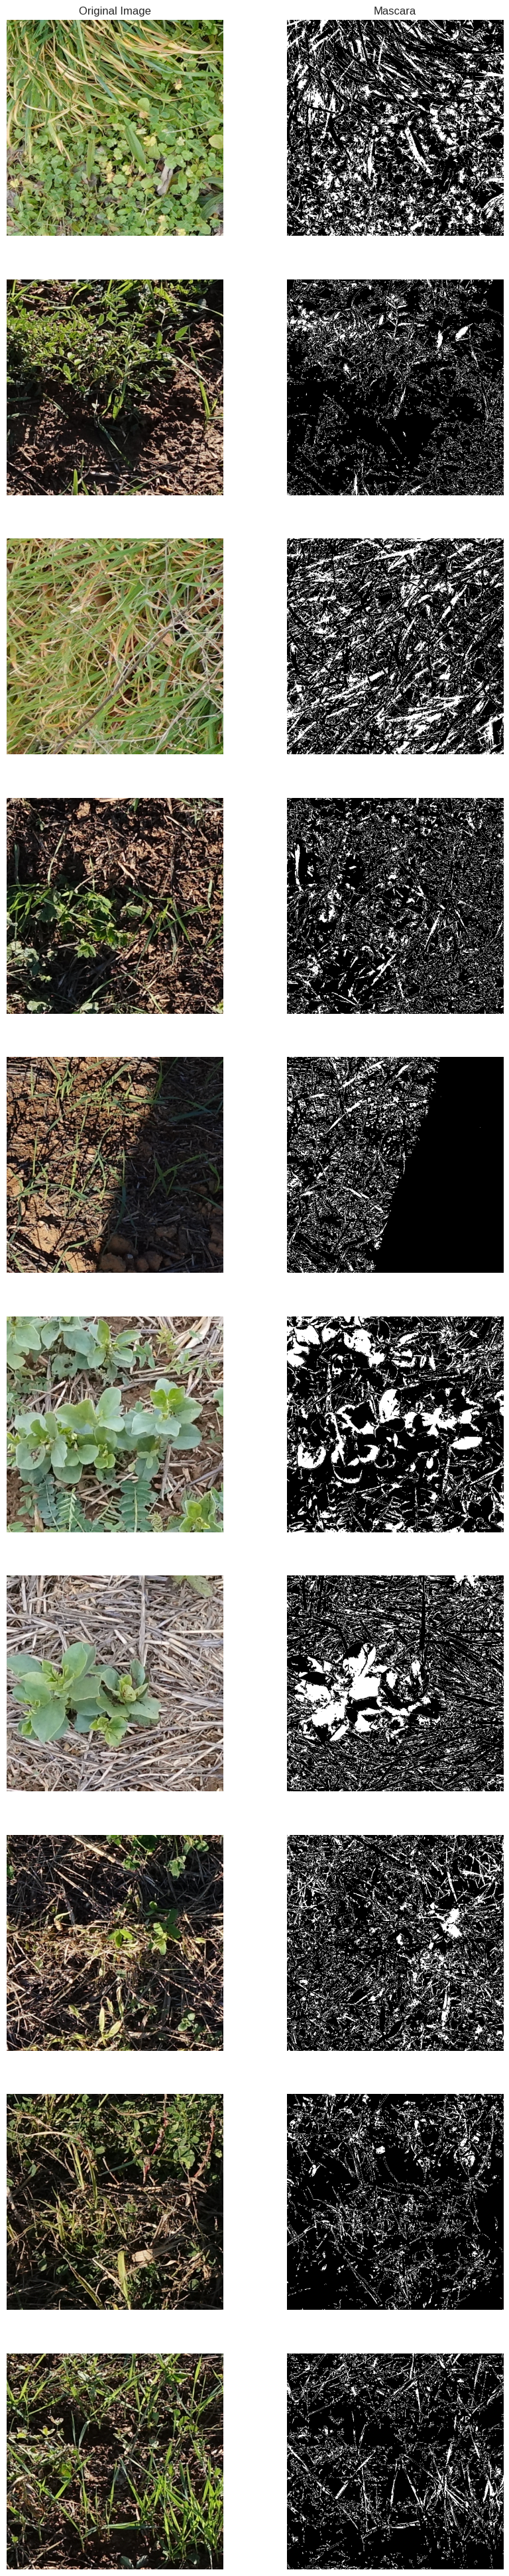

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(10, 5*10))
# n = 99
for i, (ax_or, ax_mask) in enumerate(axs):
    # Plot imagen original
    ax_or.imshow(X_imgs[indx[i]])
    ax_or.axis('off')

    # Plot máscara obtenida
    ax_mask.imshow(masks[indx[i]], cmap='gray', vmin=0, vmax=1)
    ax_mask.axis('off')

    if i == 0:
        ax_or.set_title('Original Image')
        ax_mask.set_title('Mascara')

(-0.5, 511.5, 511.5, -0.5)

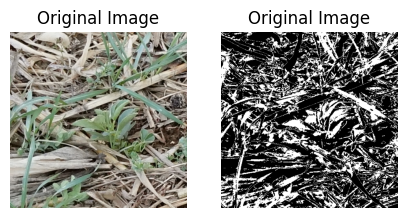

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(5, 10))
n = 99

axs[0].imshow(X_imgs[n])
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(masks[n], cmap='gray', vmin=0, vmax=1)
axs[1].set_title('Macara')
axs[1].axis('off')

## Conclusión:

El problema parece ser la definición del color verde. Si bien la segmentación puede mejorar añadiendo pasos de convolución para expandir o suavizar las partes verdes antes de realizar la clusterización por Kmeans, el problema de selección del clúster representativo de la vegetación seguirá presente si no se define apropiadamente el color verde de la planta.

Este trabajo se centró en buscar la definición de la métrica más apropiada para determinar el color verde en las plantas, y se concluyó como las imágenes en proporción de color:

-     R < 0.8G
-    B < 0.64G

Aunque en la última prueba se utilizó una condición menos estricta de R < G & B < G. Luego se calculó la media de los pixeles que cumplieran esta condición. Se probó también el número de clústeres ideales en varias imágenes, determinándose en 5.